## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [61]:
%config InlineBackend.figure_format = 'retina'
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [62]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [31]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-3-9a9c5a5dabc7>:6 

In [32]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [33]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSSSBB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1271
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|-835.8790377246141|265.03257181517876|  -309.765316879443|    352.0|SSSSSSBB| 33.3814|  -112.07|       TOBS|0.5038199540752998| 0.3887194464613411|  0.343293660417636|0.04729194803

In [79]:
#extract longitude and latitude for each station
feature='coeff_2'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,year,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,year,coeff_2 FROM weather
+-----------+--------+---------+---------+------+------------------+
|    station|latitude|longitude|elevation|  year|           coeff_2|
+-----------+--------+---------+---------+------+------------------+
|USC00028112| 33.3814|  -112.07|    352.0|2004.0|265.03257181517876|
|USC00043855| 33.7044|-115.6289|    417.6|1951.0|-465.2497603110454|
|USC00020406|    33.5|-111.9833|    381.0|1965.0|-339.1800272375209|
|USC00025467| 33.4114|-111.8183|    376.4|1971.0|-334.2068555211091|
+-----------+--------+---------+---------+------+------------------+
only showing top 4 rows



In [80]:
x = df1.toPandas()
x.sort_values(by=['station'],inplace=True)
x.head(10)

,station,latitude,longitude,elevation,year,coeff_2
688,USC00020060,33.9433,-113.1875,659.9,1941.0,-412.052945
732,USC00020060,33.9433,-113.1875,659.9,1996.0,-806.822734
511,USC00020060,33.9433,-113.1875,659.9,1991.0,-508.420447
338,USC00020060,33.9433,-113.1875,659.9,1969.0,44.476528
1057,USC00020060,33.9433,-113.1875,659.9,1961.0,-512.857906
764,USC00020060,33.9433,-113.1875,659.9,1975.0,-283.897173
877,USC00020060,33.9433,-113.1875,659.9,1957.0,103.242547
52,USC00020060,33.9433,-113.1875,659.9,1953.0,-3.504006
249,USC00020060,33.9433,-113.1875,659.9,2000.0,-690.250276
243,USC00020060,33.9433,-113.1875,659.9,1940.0,-248.936858


In [81]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_2)
40,USC00020060,33.9433,-113.1875,659.9,34,-259.113939
0,USC00020104,33.5167,-112.1167,348.1,26,-193.022085


In [82]:
pdf.count()

station           47
latitude          47
longitude         47
elevation         47
count(station)    47
avg(coeff_2)      47
dtype: int64

In [83]:
df2.toPandas().head(20)

,station,latitude,longitude,elevation,count(station),avg(coeff_2)
0,USC00020104,33.5167,-112.1167,348.1,26,-193.022085
1,USC00026603,33.7275,-111.8606,781.8,10,85.024458
2,USC00045860,34.0864,-116.5622,958.6,4,-993.320204
3,USC00029287,33.9792,-112.7403,638.6,80,-498.200636
4,USC00028112,33.3814,-112.0700,352.0,45,54.774222
5,USC00022790,33.6133,-114.4706,141.7,22,-568.642532
6,USC00025467,33.4114,-111.8183,376.4,66,-472.907943
7,USC00023852,33.5333,-113.1667,371.9,6,-70.778724
8,USC00029634,33.5950,-112.3014,345.9,29,-633.315893
9,USC00021161,33.4833,-111.9667,381.0,39,-299.023084


In [84]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

print get_color(1000.)

def draw_bar(feature = feature):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    # Make a figure and axes with dimensions as desired.
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.
    cmap = plt.get_cmap('jet') #mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=_min, vmax=_max)

    # ColorbarBase derives from ScalarMappable and puts a colorbar
    # in a specified axes, so it has everything needed for a
    # standalone colorbar.  There are many more kwargs, but the
    # following gives a basic continuous colorbar with ticks
    # and labels.
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label(feature)

    plt.show()

#800000


## Map

In [85]:
min_lat,max_lat,min_long,max_long = box = (33.2, 34.1, -117, -111)

In [86]:
def draw_map(topo=False):
    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
    zoom = 9

    #url = 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
    url = "http://{s}.tile.opentopomap.org/{z}/{x}/{y}.png" 
    provider = TileLayer(url=url, opacity=1)
    if topo==True:
        m = Map(default_tiles=provider, center=center, zoom=zoom)
    else:
        m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

    r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
    m += r

    lat_margin=(max_lat-min_lat)/4
    long_margin=(max_long-min_long)/4
    circles = []
    for index,row in pdf.iterrows():
        _lat=row['latitude']
        _long=row['longitude']
        _count=row['count(station)']
        _coef=row[_avg]
        # taking sqrt of count so that the  area of the circle corresponds to the count
        c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
                color='#000', opacity=0.8, fill_opacity=0.4,
                fill_color=get_color(_coef))
        circles.append(c)
        m.add_layer(c)
    return m

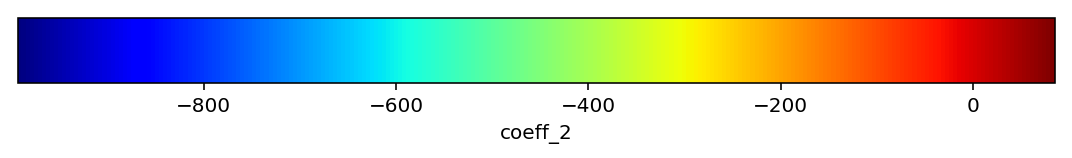

In [87]:
draw_bar()
draw_map()

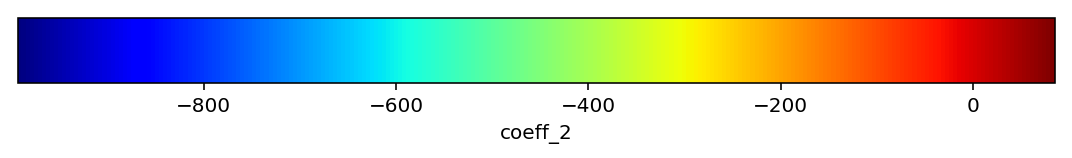

In [88]:
draw_bar()
draw_map(topo=True)

In [64]:
Map?

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [71]:
pdf

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
40,USC00020060,33.9433,-113.1875,659.9,34,450.358303
0,USC00020104,33.5167,-112.1167,348.1,26,-258.625111
38,USC00020406,33.5000,-111.9833,381.0,4,885.584545
36,USC00020949,33.9431,-114.0242,281.9,45,-706.875173
19,USC00021026,33.3761,-112.5828,271.3,22,174.961500
9,USC00021161,33.4833,-111.9667,381.0,39,101.222397
34,USC00021282,33.8161,-111.9019,771.1,35,-518.240261
41,USC00021353,33.9825,-112.3617,606.6,49,-133.389440
30,USC00021356,34.0500,-112.3500,854.0,8,-227.671294
28,USC00021361,33.8333,-111.9500,647.1,10,-92.932906


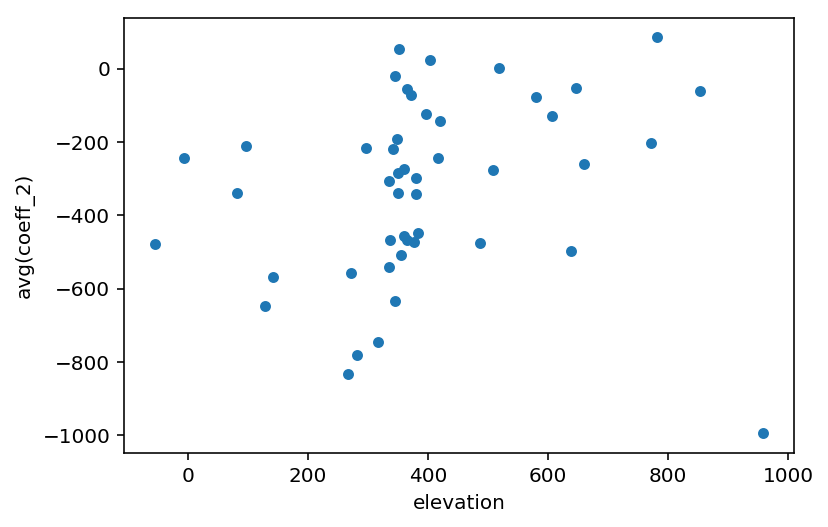

In [89]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(%s)' % feature);

In [13]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']